In [3]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/scripts"))
import auxiliar as aux
import geometry as geom

# Configuration and paths

In [4]:
# Source specifications
source_name = "crab"

# Run numbers
runs = [ 1615,  1616,  1617,  1618,  1619,  1620,  1621,  1622,  1626,
        1627,  1628,  1629,  1630,  1631,  1632,  1633,  1647,  1648,
        1649,  1650,  1651,  1652,  1653,  1698,  1700,  1701,  1702,
        1787,  1788,  1792,  1793,  1794,  1795,  1796,  1797,  1798,
        1799,  1800,  1801,  1807,  1808,  1809,  1810,  1812,  1814,
        1815,  1816,  1817,  1818,  1819,  1820,  1821,  1822,  1823,
        1824,  1825,  1832,  1833,  1834,  1835,  1836,  1837,  1840,
        1841,  1842,  1843,  1844,  1874,  1875,  1876,  1877,  1878,
        1879,  1880,  1881,  1887,  1888,  1891,  1892,  1893,  1918,
        1919,  1920,  1921,  1924,  1925,  1926,  1927,  1928,  1929,
        1930,  1931,  1932,  1933,  1948,  1949,  1951,  1952,  1953,
        1954,  1955,  1969,  1970,  1971,  1987,  1988,  1990,  1991,
        1992,  1996,  1997,  1998,  1999,  2000,  2001,  2002,  2003,
        2004,  2007,  2008,  2009,  2010,  2011,  2012,  2013,  2014,
        2031,  2032,  2033,  2036,  2037,  2075,  2076,  2077,  2113,
        2114,  2115,  2116,  2117,  2130,  2131,  2132,  2133,  2134,
        2137,  2138,  2139,  2140,  2141,  2142,  2143,  2144,  2177,
        2178,  2179,  2180,  2181,  2182,  2185,  2189,  2190,  2191,
        2193,  2194,  2195,  2196,  2202,  2203,  2205,  2206,  2207,
        2208,  2209,  2210,  2211,  2212,  2213,  2214,  2215,  2216,
        2217,  2240,  2241,  2243,  2249,  2272,  2273,  2274,  2275,
        2276,  2277,  2278,  2279,  2280,  2281,  2288,  2289,  2290,
        2291,  2298,  2299,  2341,  2342,  2344,  2346,  2348,  2350,
        2351,  2352,  2353,  2354,  2355,  2356,  2358,  2359,  2360,
        2361,  2362,  2370,  2371,  2372,  2373,  2374,  2375,  2380,
        2381,  2408,  2409,  2410,  2411,  2412,  2413,  2414,  2415,
        2416,  2419,  2420,  2421,  2422,  2426,  2427,  2428,  2430,
        2431,  2432,  2436,  2438,  2442,  2443,  2444,  2445,  2446,
        2447,  2449,  2450,  2451,  2453,  2454,  2463,  2464,  2465,
        2466,  2468,  2469,  2484,  2485,  2486,  2487,  2504,  2505,
        2506,  2507,  2508,  2509,  2510,  2511,  2512,  2514,  2517,
        2518,  2519,  2520,  2522,  2529,  2530,  2531,  2532,  2533,
        2534,  2535,  2536,  2537,  2539,  2542,  2544,  2586,  2587,
        2588,  2591,  2592,  2593,  2594,  2606,  2607,  2608,  2610,
        2612,  2613,  2686,  2687,  2688,  2691,  2692,  2693,  2707,
        2708,  2709,  2710,  2711,  2712,  2713,  2714,  2747,  2751,
        2758,  2759,  2760,  2761,  2766,  2767,  2768,  2769,  2770,
        2771,  2836,  2837,  2853,  2854,  2855,  2909,  2911,  2912,
        2913,  2914,  2915,  2916,  2917,  2918,  2919,  2922,  2923,
        2924,  2925,  2926,  2927,  2928,  2929,  2930,  2931,  2932,
        2933,  2934,  2949,  2950,  2952,  2953,  2954,  2955,  2956,
        2957,  2958,  2959,  2960,  2961,  2965,  2966,  2967,  2968,
        2969,  2970,  2971,  2972,  2973,  2974,  2975,  2976,  2977,
        2978,  2979,  2980,  2981,  2988,  2989,  2990,  2991,  2992,
        2993,  2994,  2995,  2996,  2999,  3000,  3001,  3002,  3003,
        3004,  3005,  3006,  3007,  3008,  3009,  3010,  3011,  3012,
        3065,  3066,  3067,  3068,  3071,  3072,  3073,  3087,  3088,
        3089,  3090,  3093,  3094,  3095,  3096,  3097,  3098,  3099,
        3100,  3101,  3143,  3144,  3169,  3170,  3171,  3216,  3217,
        3218,  3219,  3220,  3221,  3222,  3223,  3224,  3225,  3226,
        3227,  3231,  3232,  3233,  3234,  3235,  3236,  3237,  3238,
        3239,  3243,  3244,  3245,  3246,  3247,  3248,  3249,  3250,
        3264,  3265,  3266,  3267,  3268,  3269,  3270,  3271,  3272,
        3273,  3274,  3275,  3276,  3277,  3278,  3279,  3281,  3282,
        3283,  3284,  3285,  3286,  3287,  3288,  3314,  3315,  3316,
        3317,  3318,  3319,  3320,  3321,  3324,  3325,  3326,  3327,
        3328,  3329,  3330,  3331,  3332,  3333,  3334,  3335,  3338,
        3339,  3340,  3341,  3342,  3343,  3344,  3345,  3346,  3347,
        3348,  3349,  3350,  3355,  3356,  3357,  3358,  3359,  3360,
        3361,  3362,  3363,  3364,  3373,  3374,  3375,  3382,  3383,
        3384,  3385,  3514,  3515,  3516,  3539,  3583,  3584,  3585,
        3586,  3589,  3590,  3591,  3592,  3598,  3599,  3600,  3601,
        3603,  3604,  3605,  3606,  3608,  3615,  3616,  3617,  3618,
        3619,  3620,  3621,  3622,  3623,  3624,  3631,  3632,  3633,
        3634,  3635,  3636,  3637,  3638,  3639,  3641,  3642,  3644,
        3645,  3646,  3649,  3650,  3651,  3652,  3653,  3654,  3655,
        3656,  3657,  3658,  3659,  3661,  3662,  3663,  3664,  3665,
        3666,  3667,  3668,  3672,  3673,  3674,  3675,  3676,  3677,
        3678,  3679,  3680,  3681,  3682,  3683,  3684,  3687,  3688,
        3689,  3690,  3691,  3692,  3693,  3694,  3695,  3697,  3698,
        3699,  3703,  3704,  3705,  3706,  3707,  3708,  3709,  3710,
        3711,  3712,  3715,  3716,  3717,  3718,  3720,  3721,  3725,
        3726,  3727,  3728,  3729,  3730,  3732,  3733,  3734,  3735,
        3736,  3737,  3738,  3739,  3741,  3742,  3743,  3744,  3745,
        3746,  3747,  3748,  3800,  3894,  3895,  3897,  3898,  3925,
        3946,  3947,  3948,  3949,  3950,  3953,  3954,  3955,  3956,
        3957,  3959,  3960,  3961,  3962,  3973,  3974,  3975,  3976,
        3977,  3979,  3980,  3981,  3982,  3983,  4007,  4008,  4009,
        4010,  4011,  4012,  4013,  4014,  4015,  4016,  4017,  4018,
        4019,  4027,  4028,  4029,  4030,  4031,  4032,  4033,  4034,
        4035,  4036,  4037,  4039,  4040,  4041,  4042,  4043,  4044,
        4045,  4046,  4047,  4048,  4049,  4050,  4051,  4052,  4054,
        4056,  4057,  4058,  4059,  4060,  4061,  4062,  4063,  4066,
        4067,  4068,  4069,  4070,  4071,  4073,  4074,  4075,  4077,
        4086,  4087,  4088,  4089,  4090,  4091,  4092,  4093,  4094,
        4095,  4097,  4098,  4099,  4100,  4101,  4102,  4103,  4104,
        4125,  4126,  4127,  4128,  4129,  4131,  4132,  4133,  4134,
        4135,  4136,  4137,  4138,  4139,  4140,  4145,  4146,  4147,
        4148,  4149,  4153,  4154,  4155,  4156,  4167,  4168,  4169,
        4170,  4171,  4172,  4173,  4174,  4175,  4176,  4177,  4180,
        4181,  4182,  4184,  4185,  4186,  4187,  4188,  4189,  4190,
        4191,  4192,  4193,  4194,  4195,  4197,  4198,  4199,  4200,
        4201,  4202,  4203,  4204,  4205,  4206,  4207,  4208,  4212,
        4213,  4214,  4215,  4333,  4334,  4335,  4336,  4343,  4344,
        4363,  4364,  4365,  4366,  4367,  4368,  4369,  4370,  4371,
        4372,  4383,  4385,  4386,  4387,  4388,  4389,  4390,  4391,
        4395,  4396,  4397,  4398,  4441,  4442,  4443,  4444,  4445,
        4446,  4447,  4448,  4449,  4450,  4451,  4452,  4453,  4454,
        4455,  4457,  4458,  4459,  4460,  4461,  4462,  4463,  4464,
        4465,  4467,  4468,  4473,  4474,  4475,  4476,  4479,  4480,
        4483,  4484,  4486,  4487,  4488,  4490,  4491,  4492,  4493,
        4494,  4495,  4496,  4497,  4498,  4500,  4501,  4502,  4503,
        4506,  4507,  4508,  4509,  4511,  4512,  4513,  4514,  4515,
        4516,  4517,  4518,  4519,  4568,  4569,  4570,  4571,  4572,
        4586,  4587,  4588,  4589,  4590,  4594,  4595,  4597,  4598,
        4599,  4600,  4601,  4602,  4603,  4604,  4605,  4606,  4607,
        4612,  4613,  4614,  4615,  4616,  4625,  4626,  4627,  4628,
        4629,  4630,  4631,  4632,  4636,  4637,  4638,  4639,  4640,
        4641,  4642,  4643,  4644,  4645,  4649,  4652,  4653,  4654,
        4656,  4657,  4660,  4661,  4662,  4663,  4667,  4668,  4669,
        4670,  4671,  4672,  4673,  4674,  4675,  4676,  4677,  4679,
        4680,  4681,  4682,  4683,  4684,  4697,  4698,  4699,  4700,
        4701,  4702,  4717,  4718,  4719,  4720,  4721,  4724,  4725,
        4726,  4727,  4728,  4729,  4730,  4731,  4732,  4733,  4734,
        4735,  4738,  4741,  4742,  4743,  4744,  4745,  4777,  4778,
        4779,  4780,  4781,  4782,  4783,  4786,  4787,  4788,  4789,
        4790,  4791,  4792,  4793,  4802,  4819,  4820,  4822,  4823,
        4824,  4825,  4826,  4840,  4841,  4843,  4844,  4845,  4846,
        4847,  4848,  4849,  4852,  4853,  4855,  4856,  4858,  4859,
        4861,  4862,  4863,  4864,  4865,  4868,  4869,  4870,  4871,
        4873,  4874,  4875,  4876,  4877,  4885,  4886,  4887,  4888,
        4889,  4890,  4891,  4892,  4893,  4894,  4895,  4896,  4897,
        4898,  4899,  4902,  4903,  4904,  4905,  4906,  4907,  4908,
        4909,  4910,  4911,  4912,  4913,  4914,  4915,  4916,  4917,
        4918,  4921,  4922,  4923,  4924,  4925,  4926,  4927,  4928,
        4929,  4930,  4931,  4932,  4933,  4934,  4935,  4936,  4939,
        4940,  4941,  4942,  4943,  4944,  4945,  4946,  4947,  4948,
        4949,  4950,  4951,  4952,  4953,  4954,  4955,  4962,  4963,
        4964,  4965,  4966,  4967,  4968,  4969,  4970,  4971,  4972,
        4973,  4974,  4975,  4976,  4977,  4979,  4980,  4981,  4982,
        4985,  4986,  4987,  4988,  4989,  4991,  4992,  4993,  4994,
        4995,  4996,  4997,  4998,  4999,  5000,  5001,  5002,  5011,
        5028,  5029,  5030,  5031,  5032,  5033,  5034,  5036,  5037,
        5038,  5039,  5040,  5043,  5044,  5045,  5046,  5047,  5048,
        5049,  5050,  5051,  5052,  5053,  5054,  5056,  5057,  5062,
        5063,  5064,  5065,  5071,  5072,  5079,  5080,  5081,  5082,
        5083,  5084,  5088,  5089,  5090,  5091,  5092,  5093,  5094,
        5095,  5096,  5097,  5100,  5101,  5102,  5103,  5104,  5105,
        5106,  5107,  5108,  5109,  5110,  5111,  5112,  5115,  5116,
        5117,  5118,  5119,  5120,  5121,  5131,  5132,  5134,  5135,
        5136,  5137,  5138,  5139,  5140,  5141,  5142,  5154,  5155,
        5156,  5157,  5158,  5161,  5162,  5163,  5164,  5165,  5166,
        5167,  5168,  5169,  5170,  5171,  5175,  5176,  5192,  5193,
        5194,  5195,  5196,  5197,  5198,  5199,  5202,  5203,  5204,
        5205,  5206,  5207,  5208,  5211,  5212,  5213,  5214,  5215,
        5216,  5217,  5218,  5219,  5220,  5223,  5224,  5225,  5226,
        5227,  5228,  5229,  5230,  5231,  5232,  5233,  5234,  5235,
        5240,  5241,  5242,  5251,  5252,  5253,  5254,  5255,  5256,
        5257,  5258,  5270,  5272,  5273,  5274,  5275,  5276,  5277,
        5281,  5282,  5283,  5284,  5285,  5286,  5287,  5288,  5289,
        5294,  5295,  5299,  5300,  5301,  5302,  5303,  5304,  5318,
        5320,  5321,  5322,  5326,  5327,  5328,  5329,  5330,  5335,
        5336,  5373,  5374,  5394,  5395,  5400,  5401,  5402,  5403,
        5404,  5405,  5411,  5412,  5413,  5414,  5421,  5422,  5423,
        5425,  5426,  5427,  5432,  5435,  5436,  5437,  5438,  5439,
        5440,  5441,  5442,  5443,  5444,  5447,  5448,  5449,  5450,
        5453,  5454,  5455,  5456,  5457,  5458,  5460,  5461,  5462,
        5463,  5464,  5465,  5466,  5473,  5474,  5475,  5476,  5477,
        5478,  5479,  5480,  5481,  5482,  5486,  5488,  5489,  5490,
        5491,  5492,  5493,  5494,  5497,  5498,  5499,  5500,  5503,
        5504,  5505,  5506,  5507,  5508,  5509,  5510,  5511,  5512,
        5513,  5514,  5515,  5516,  5517,  5520,  5521,  5522,  5523,
        5524,  5525,  5526,  5527,  5528,  5529,  5530,  5531,  5532,
        5533,  5535,  5536,  5537,  5540,  5542,  5543,  5544,  5545,
        5546,  5547,  5550,  5551,  5552,  5553,  5554,  5555,  5556,
        5557,  5558,  5559,  5576,  5577,  5580,  5581,  5582,  5583,
        5584,  5590,  5591,  5592,  5593,  5594,  5595,  5630,  5631,
        5632,  5633,  5634,  5635,  5636,  5637,  5638,  5639,  5640,
        5641,  5642,  5643,  5644,  5645,  5646,  5680,  5681,  5682,
        5683,  5684,  5685,  5686,  5687,  5688,  5689,  5690,  5691,
        5692,  5693,  5696,  5697,  5698,  5699,  5700,  5701,  5702,
        5703,  5704,  5705,  5706,  5707,  5708,  5709,  5710,  5711,
        5712,  5713,  5714,  5715,  5716,  5719,  5722,  5723,  5724,
        5725,  5726,  5727,  5728,  5730,  5731,  5732,  5733,  5734,
        5735,  5736,  5737,  5738,  5742,  5743,  5744,  5745,  5746,
        5747,  5748,  5749,  5750,  5751,  5752,  5753,  5754,  5755,
        5756,  5757,  5758,  5759,  5763,  5764,  5765,  5766,  5767,
        5768,  5769,  5770,  5771,  5772,  5773,  5774,  5775,  5776,
        5777,  5780,  5781,  5783,  5784,  5785,  5786,  5795,  5798,
        5799,  5800,  5890,  5891,  5892,  5893,  5894,  5895,  5896,
        5912,  5913,  5914,  5915,  5916,  5917,  5918,  5919,  5920,
        5921,  5942,  5943,  5944,  5945,  5947,  5948,  5949,  5950,
        5952,  5953,  5954,  5955,  5956,  5957,  5958,  5970,  5971,
        5972,  5973,  5980,  5981,  5982,  5983,  5984,  5985,  5986,
        5987,  5988,  5989,  5990,  5991,  5992,  5993,  5994,  5995,
        5998,  5999,  6000,  6001,  6002,  6003,  6004,  6005,  6006,
        6007,  6008,  6009,  6010,  6011,  6012,  6013,  6014,  6016,
        6020,  6021,  6022,  6023,  6024,  6026,  6034,  6035,  6036,
        6037,  6038,  6039,  6040,  6041,  6042,  6043,  6044,  6045,
        6057,  6058,  6059,  6060,  6061,  6062,  6063,  6064,  6065,
        6066,  6068,  6069,  6070,  6071,  6072,  6073,  6076,  6077,
        6078,  6079,  6080,  6082,  6083,  6084,  6085,  6118,  6119,
        6120,  6121,  6122,  6125,  6126,  6127,  6128,  6129,  6130,
        6131,  6132,  6133,  6134,  6135,  6137,  6138,  6139,  6140,
        6141,  6142,  6143,  6144,  6145,  6146,  6147,  6148,  6150,
        6151,  6152,  6157,  6158,  6159,  6160,  6161,  6162,  6163,
        6164,  6165,  6166,  6167,  6168,  6169,  6170,  6171,  6172,
        6175,  6176,  6177,  6178,  6179,  6180,  6181,  6182,  6183,
        6184,  6185,  6186,  6188,  6189,  6190,  6191,  6192,  6193,
        6194,  6195,  6198,  6199,  6200,  6201,  6202,  6203,  6204,
        6205,  6206,  6208,  6209,  6210,  6211,  6212,  6213,  6214,
        6223,  6224,  6225,  6226,  6227,  6228,  6229,  6230,  6231,
        6232,  6233,  6234,  6235,  6236,  6237,  6238,  6239,  6240,
        6241,  6242,  6244,  6245,  6246,  6247,  6248,  6249,  6250,
        6251,  6252,  6253,  6254,  6255,  6256,  6257,  6258,  6259,
        6260,  6261,  6262,  6263,  6264,  6265,  6266,  6267,  6269,
        6271,  6272,  6273,  6275,  6276,  6277,  6278,  6279,  6281,
        6282,  6288,  6289,  6290,  6291,  6294,  6295,  6296,  6297,
        6298,  6299,  6301,  6302,  6303,  6304,  6308,  6310,  6311,
        6312,  6313,  6314,  6315,  6323,  6324,  6851,  6852,  6853,
        6854,  6855,  6858,  6859,  6860,  6861,  6862,  6863,  6864,
        6865,  6871,  6872,  6873,  6874,  6875,  6876,  6877,  6878,
        6879,  6880,  6881,  6882,  6887,  6888,  6889,  6890,  6891,
        6892,  6893,  6894,  6895,  6896,  6897,  6898,  6900,  6901,
        6902,  6903,  6927,  6928,  6929,  6930,  6931,  6935,  6936,
        6937,  6938,  6939,  6940,  6941,  6943,  6944,  6945,  6947,
        6948,  6949,  6950,  6951,  6952,  6953,  6954,  6955,  6956,
        6957,  6958,  6959,  6962,  6963,  6964,  6965,  6966,  6967,
        6968,  6969,  6975,  6976,  6977,  6978,  6979,  6980,  6981,
        6990,  6992,  6993,  6994,  6995,  6996,  6997,  6998,  6999,
        7001,  7002,  7004,  7005,  7006,  7007,  7009,  7010,  7022,
        7023,  7024,  7025,  7026,  7029,  7030,  7031,  7032,  7033,
        7034,  7035,  7036,  7043,  7046,  7047,  7048,  7049,  7084,
        7086,  7087,  7088,  7097,  7098,  7099,  7100,  7101,  7102,
        7105,  7106,  7133,  7134,  7135,  7136,  7137,  7138,  7139,
        7140,  7141,  7142,  7143,  7144,  7145,  7146,  7147,  7148,
        7149,  7150,  7151,  7152,  7153,  7154,  7155,  7156,  7157,
        7158,  7161,  7168,  7169,  7170,  7171,  7172,  7173,  7174,
        7175,  7176,  7177,  7178,  7179,  7180,  7181,  7182,  7183,
        7184,  7185,  7186,  7187,  7188,  7189,  7195,  7196,  7197,
        7198,  7199,  7200,  7201,  7202,  7203,  7204,  7205,  7206,
        7207,  7208,  7209,  7210,  7211,  7212,  7213,  7214,  7215,
        7216,  7217,  7218,  7219,  7220,  7221,  7227,  7228,  7229,
        7230,  7231,  7232,  7233,  7234,  7235,  7236,  7237,  7238,
        7239,  7240,  7241,  7242,  7243,  7244,  7245,  7246,  7247,
        7248,  7249,  7250,  7253,  7254,  7255,  7256,  7258,  7259,
        7266,  7267,  7268,  7269,  7270,  7271,  7274,  7275,  7276,
        7277,  7278,  7279,  7280,  7281,  7282,  7283,  7284,  7285,
        7286,  7287,  7289,  7290,  7291,  7292,  7293,  7294,  7295,
        7296,  7297,  7298,  7301,  7302,  7303,  7304,  7305,  7306,
        7307,  7308,  7309,  7310,  7313,  7314,  7315,  7316,  7317,
        7318,  7321,  7322,  7323,  7324,  7325,  7326,  7329,  7330,
        7331,  7332,  7333,  7334,  7335,  7336,  7337,  7338,  7339,
        7340,  7341,  7342,  7343,  7348,  7349,  7351,  7352,  7353,
        7354,  7355,  7356,  7357,  7358,  7359,  7360,  7361,  7362,
        7363,  7364,  7366,  7367,  7368,  7369,  7370,  7371,  7372,
        7373,  7374,  7375,  7376,  7377,  7378,  7381,  7382,  7383,
        7384,  7385,  7389,  7390,  7391,  7393,  7394,  7395,  7396,
        7397,  7398,  7399,  7401,  7402,  7403,  7406,  7407,  7408,
        7409,  7410,  7411,  7412,  7413,  7414,  7415,  7416,  7417,
        7418,  7419,  7420,  7421,  7422,  7423,  7425,  7426,  7427,
        7428,  7434,  7435,  7441,  7444,  7453,  7455,  7456,  7457,
        7458,  7459,  7460,  7461,  7465,  7466,  7467,  7468,  7469,
        7470,  7471,  7472,  7473,  7474,  7475,  7476,  7477,  7478,
        7479,  7480,  7481,  7482,  7483,  7484,  7485,  7486,  7487,
        7488,  7489,  7490,  7517,  7518,  7519,  7520,  7521,  7522,
        7523,  7524,  7525,  7526,  7527,  7528,  7531,  7532,  7533,
        7534,  7535,  7537,  7564,  7565,  7566,  7567,  7568,  7569,
        7570,  7605,  7606,  7607,  7608,  7609,  7610,  7611,  7612,
        7615,  7616,  7617,  7618,  7619,  7620,  7621,  7623,  7624,
        7625,  7626,  7627,  7628,  7629,  7630,  7631,  7632,  7633,
        7634,  7635,  7636,  7637,  7638,  7639,  7640,  7641,  7642,
        7643,  7644,  7645,  7648,  7649,  7650,  7653,  7654,  7655,
        7656,  7657,  7683,  7684,  7685,  7686,  7687,  7688,  7689,
        7690,  7692,  7694,  7695,  7696,  7697,  7698,  7699,  7700,
        7701,  7702,  7704,  7709,  7710,  7711,  7712,  7713,  7714,
        7715,  7716,  7718,  7719,  7720,  7721,  7722,  7723,  7724,
        7725,  7726,  7727,  7728,  7729,  7730,  7735,  7736,  7737,
        7738,  7739,  7740,  7741,  7742,  7746,  7747,  7748,  7749,
        7751,  7752,  7753,  7754,  7755,  7756,  7757,  7761,  7762,
        7763,  7764,  7765,  7766,  7767,  7768,  7769,  7770,  7773,
        7775,  7776,  7777,  7778,  7779,  7780,  7783,  7784,  7785,
        7786,  7787,  7788,  7790,  7791,  7792,  7794,  7795,  7796,
        7797,  7798,  7825,  7826,  7827,  7828,  7849,  7850,  7851,
        7852,  7854,  7855,  7856,  7857,  7858,  7859,  7860,  7861,
        7862,  7863,  7867,  7868,  7869,  7870,  7871,  7872,  7873,
        7874,  7875,  7876,  7877,  7880,  7882,  7883,  7884,  7889,
        7890,  7891,  7892,  7893,  7896,  7897,  7898,  7903,  7904,
        7905,  7906,  7907,  7908,  7909,  7910,  7911,  7912,  7913,
        7914,  7915,  7916,  7917,  7918,  7962,  7963,  7964,  7965,
        7966,  7967,  7968,  7969,  7970,  7971,  7972,  7973,  7974,
        7975,  7976,  7977,  7978,  7979,  7980,  7981,  7982,  7985,
        7987,  7988,  7989,  7990,  7991,  7992,  7993,  7995,  8000,
        8001,  8002,  8004,  8005,  8006,  8007,  8009,  8010,  8011,
        8012,  8013,  8014,  8015,  8016,  8019,  8021,  8022,  8023,
        8024,  8025,  8027,  8028,  8029,  8030,  8031,  8032,  8033,
        8034,  8035,  8036,  8037,  8038,  8039,  8040,  8041,  8042,
        8043,  8044,  8045,  8046,  8048,  8049,  8050,  8051,  8052,
        8053,  8056,  8057,  8058,  8059,  8060,  8061,  8062,  8063,
        8064,  8065,  8066,  8067,  8072,  8073,  8074,  8075,  8076,
        8077,  8078,  8079,  8080,  8081,  8082,  8083,  8084,  8085,
        8086,  8087,  8088,  8092,  8093,  8094,  8095,  8096,  8097,
        8099,  8100,  8101,  8102,  8103,  8104,  8105,  8106,  8107,
        8108,  8109,  8110,  8111,  8112,  8113,  8114,  8116,  8117,
        8118,  8119,  8120,  8121,  8123,  8124,  8125,  8126,  8127,
        8128,  8129,  8132,  8133,  8134,  8135,  8136,  8138,  8139,
        8180,  8181,  8182,  8183,  8184,  8185,  8188,  8189,  8191,
        8192,  8197,  8198,  8199,  8200,  8201,  8202,  8203,  8204,
        8207,  8208,  8209,  8211,  8212,  8213,  8214,  8215,  8216,
        8217,  8219,  8220,  8221,  8222,  8223,  8224,  8225,  8226,
        8227,  8228,  8229,  8230,  8231,  8232,  8237,  8238,  8239,
        8240,  8241,  8242,  8243,  8244,  8245,  8246,  8247,  8249,
        8250,  8252,  8253,  8254,  8255,  8256,  8257,  8258,  8259,
        8260,  8263,  8264,  8265,  8266,  8267,  8268,  8269,  8270,
        8271,  8272,  8273,  8274,  8275,  8276,  8278,  8279,  8280,
        8281,  8282,  8283,  8284,  8289,  8290,  8292,  8293,  8294,
        8297,  8298,  8299,  8300,  8301,  8304,  8306,  8307,  8308,
        8309,  8310,  8311,  8325,  8326,  8328,  8329,  8330,  8331,
        8350,  8351,  8352,  8353,  8354,  8359,  8360,  8361,  8362,
        8364,  8365,  8366,  8367,  8374,  8375,  8376,  8377,  8378,
        8379,  8381,  8382,  8383,  8386,  8387,  8388,  8389,  8390,
        8391,  8392,  8393,  8394,  8395,  8396,  8397,  8398,  8399,
        8400,  8401,  8402,  8403,  8406,  8407,  8408,  8409,  8411,
        8412,  8413,  8414,  8415,  8416,  8417,  8418,  8419,  8422,
        8423,  8424,  8425,  8435,  8436,  8437,  8438,  8439,  8440,
        8441,  8442,  8443,  8444,  8445,  8446,  8447,  8448,  8449,
        8450,  8451,  8455,  8456,  8457,  8458,  8459,  8460,  8461,
        8462,  8463,  8467,  8468,  8469,  8470,  8473,  8474,  8475,
        8476,  8477,  8478,  8485,  8486,  8487,  8488,  8489,  8490,
        8491,  8492,  8493,  8494,  8496,  8501,  8504,  8505,  8506,
        8507,  8508,  8509,  8510,  8511,  8512,  8513,  8514,  8515,
        8516,  8517,  8518,  8519,  8520,  8521,  8522,  8523,  8526,
        8527,  8558,  8559,  8560,  8561,  8562,  8563,  8564,  8565,
        8566,  8567,  8568,  8569,  8570,  8571,  8572,  8576,  8577,
        8578,  8579,  8580,  8581,  8582,  8583,  8584,  8585,  8586,
        8587,  8588,  8589,  8592,  8593,  8594,  8595,  8596,  8597,
        8598,  8599,  8600,  8601,  8602,  8603,  8604,  8605,  8606,
        8607,  8608,  8609,  8610,  8611,  8612,  8613,  8614,  8617,
        8618,  8619,  8620,  8621,  8622,  8623,  8624,  8625,  8626,
        8627,  8628,  8629,  8630,  8631,  8632,  8633,  8634,  8635,
        8636,  8640,  8641,  8642,  8643,  8644,  8645,  8646,  8647,
        8648,  8649,  8650,  8651,  8652,  8653,  8655,  8656,  8657,
        8658,  8659,  8660,  8661,  8662,  8665,  8666,  8667,  8668,
        8669,  8670,  8671,  8672,  8676,  8697,  8698,  8706,  8707,
        8708,  8709,  8710,  8711,  8712,  8713,  8714,  8715,  8716,
        8717,  8718,  8719,  8720,  8721,  8722,  8723,  8724,  8725,
        8744,  8745,  8746,  8747,  8748,  8749,  8750,  8751,  8752,
        8753,  8754,  8755,  8756,  8757,  8786,  8787,  8790,  8791,
        8792,  8793,  8794,  8795,  8796,  8797,  8798,  8799,  8800,
        8801,  8802,  8803,  8804,  8805,  8806,  8807,  8808,  8809,
        8817,  8818,  8819,  8820,  8821,  8822,  8823,  8824,  8825,
        8834,  8837,  8838,  8839,  8840,  8844,  8845,  8846,  8847,
        8848,  8849,  8850,  8851,  8854,  8855,  8860,  8861,  8862,
        8863,  8864,  8865,  8866,  8867,  8868,  8869,  8870,  8871,
        8872,  8873,  8874,  8875,  8878,  8879,  8880,  8881,  8882,
        8883,  8884,  8885,  8886,  8887,  8888,  8889,  8890,  8891,
        8892,  8893,  8894,  8895,  8896,  8897,  8898,  8899,  8902,
        8903,  8904,  8905,  8906,  8907,  8908,  8909,  8910,  8911,
        8912,  8913,  8914,  8935,  8936,  8940,  8941,  8942,  8943,
        8944,  8945,  8946,  8947,  8948,  8949,  8950,  8951,  8952,
        8953,  8954,  8955,  8956,  8957,  8958,  8959,  8968,  8969,
        8970,  8971,  8972,  8973,  8974,  8975,  8976,  8977,  8978,
        8979,  8980,  8981,  8982,  8983,  8984,  8985,  8986,  8987,
        8988,  8989,  8990,  9228,  9229,  9230,  9231,  9232,  9247,
        9248,  9249,  9250,  9251,  9252,  9253,  9259,  9260,  9261,
        9262,  9263,  9264,  9265,  9266,  9267,  9268,  9269,  9270,
        9271,  9272,  9273,  9274,  9275,  9276,  9277,  9278,  9279,
        9280,  9281,  9347,  9348,  9349,  9350,  9351,  9352,  9353,
        9354,  9355,  9356,  9357,  9359,  9360,  9361,  9362,  9363,
        9364,  9365,  9367,  9368,  9369,  9370,  9415,  9416,  9417,
        9418,  9419,  9434,  9435,  9436,  9437,  9438,  9442,  9443,
        9444,  9445,  9446,  9447,  9448,  9449,  9450,  9453,  9454,
        9455,  9456,  9457,  9458,  9459,  9460,  9461,  9510,  9511,
        9512,  9513,  9514,  9516,  9517,  9518,  9519,  9520,  9523,
        9524,  9525,  9526,  9527,  9528,  9529,  9530,  9531,  9544,
        9545,  9546,  9548,  9549,  9550,  9551,  9552,  9553,  9554,
        9555,  9556,  9559,  9564,  9565,  9595,  9596,  9602,  9603,
        9604,  9605,  9606,  9607,  9613,  9614,  9615,  9616,  9617,
        9625,  9626,  9627,  9628,  9629,  9630,  9631,  9632,  9633,
        9634,  9635,  9636,  9640,  9641,  9642,  9643,  9644,  9645,
        9646,  9647,  9648,  9649,  9650,  9651,  9652,  9653,  9654,
        9655,  9656,  9657,  9658,  9659,  9660,  9662,  9663,  9664,
        9665,  9666,  9670,  9671,  9672,  9673,  9674,  9675,  9676,
        9677,  9678,  9679,  9680,  9681,  9682,  9683,  9684,  9685,
        9686,  9687,  9688,  9689,  9691,  9692,  9693,  9694,  9695,
        9696,  9697,  9698,  9699,  9700,  9701,  9702,  9703,  9704,
        9705,  9706,  9714,  9715,  9716,  9722,  9723,  9724,  9725,
        9726,  9727,  9728,  9729,  9730,  9731,  9732,  9733,  9734,
        9735,  9736,  9737,  9738,  9739,  9740,  9741,  9742,  9743,
        9744,  9745,  9746,  9747,  9748,  9749,  9752,  9753,  9754,
        9755,  9756,  9757,  9758,  9759,  9760,  9761,  9786,  9787,
        9788,  9789,  9802,  9803,  9804,  9805,  9806,  9807,  9808,
        9809,  9810,  9811,  9812,  9813,  9814,  9815,  9816,  9817,
        9818,  9819,  9820,  9821,  9822,  9823,  9824,  9827,  9828,
        9829,  9830,  9831,  9832,  9833,  9834,  9835,  9836,  9843,
        9844,  9845,  9846,  9847,  9848,  9849,  9850,  9851,  9852,
        9853,  9854,  9855,  9856,  9857,  9858,  9861,  9862,  9863,
        9864,  9865,  9866,  9867,  9868,  9869,  9870,  9871,  9872,
        9873,  9874,  9875,  9876,  9877,  9878,  9879,  9880,  9881,
        9882,  9886,  9887,  9888,  9889,  9890,  9891,  9892,  9893,
        9894,  9895,  9896,  9897,  9898,  9899,  9900,  9903,  9904,
        9905,  9906,  9907,  9908,  9909,  9910,  9911,  9912,  9913,
        9914,  9917,  9918,  9919,  9920,  9921,  9922,  9923,  9924,
        9925,  9929,  9932,  9933,  9934,  9935,  9940,  9941,  9942,
        9943,  9944,  9945,  9946,  9947,  9948,  9949,  9950,  9951,
        9952,  9953,  9956,  9957,  9958,  9959,  9960,  9961,  9962,
        9963,  9964,  9965,  9966,  9967,  9968,  9969,  9970,  9971,
        9972,  9973,  9974,  9975,  9976,  9977,  9978,  9981,  9982,
        9983,  9984,  9985,  9986,  9987,  9990,  9991,  9992,  9993,
        9994,  9995,  9996,  9997,  9998,  9999, 10000, 10001, 10002,
       10003, 10004, 10005, 10006, 10007, 10008, 10009, 10011, 10012,
       10015, 10016, 10017, 10018, 10019, 10021, 10022, 10023, 10024,
       10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033,
       10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10044,
       10045, 10060, 10069, 10070, 10071, 10072, 10073, 10074, 10075,
       10076, 10077, 10078, 10079, 10080, 10081, 10082, 10083, 10084,
       10085, 10086, 10087, 10088, 10089, 10090, 10092, 10093, 10094,
       10095, 10106, 10147, 10188, 10193, 10194, 10195, 10196, 10197,
       10198, 10199, 10200, 10201, 10202, 10203, 10204, 10205, 10206,
       10207, 10208, 10209, 10210, 10211, 10212, 10213, 10214, 10215,
       10217, 10218, 10219, 10220, 10221, 10246, 10247, 10248, 10249,
       10250, 10251, 10252, 10253, 10254, 10255, 10256, 10257, 10258,
       10259, 10260, 10261, 10262, 10263, 10264, 10304, 10318, 10319,
       10320, 10321, 10322, 10323, 10324, 10325, 10326, 10327, 10328,
       10329, 10330, 10331, 10332, 10333, 10339, 10340, 10341, 10342,
       10343, 10344, 10345, 10346, 10347, 10348, 10349, 10350, 10351,
       10352, 10353, 10356, 10357, 10358, 10497, 10498, 10501, 10502,
       10503, 10504, 10505, 10506, 10507, 10508, 10509, 10510, 10511,
       10512, 10520, 10521, 10522, 10523, 10525, 10526, 10527, 10528,
       10530, 10585, 10586, 10587, 10588, 10589, 10590, 10591, 10592,
       10593, 10594, 10595, 10596, 10597, 10598, 10599, 10600, 10601,
       10602, 10603, 10604, 10611, 10612, 10613, 10614, 10615, 10616,
       10617, 10618, 10619, 10620, 10621, 10622, 10623, 10624, 10625,
       10626, 10627, 10628, 10629, 10630, 10631, 10632, 10633, 10634,
       10635, 10636, 10637, 10638, 10639, 10643, 10644, 10645, 10646,
       10647, 10648, 10649, 10650, 10651, 10652, 10653, 10654, 10655,
       10656, 10657, 10658, 10659, 10660, 10661, 10662, 10663, 10665,
       10666, 10667, 10668, 10669, 10670, 10671, 10672, 10673, 10674,
       10825, 10826, 10827, 10828, 10829, 10830, 10831, 10855, 10856,
       10857, 10858, 10859, 10860, 10861, 10862, 10863, 10864, 10865,
       10868, 10869, 10870, 10871, 10872, 10873, 10874, 10875, 10876,
       10877, 10878, 10879, 10880, 10881, 10882, 10883, 10884, 10885,
       10886, 10887, 10888, 10889, 10892, 10893, 10894, 10895, 10896,
       10897, 10898, 10899, 10900, 10901, 10902, 10903, 10904, 10905,
       10906, 10907, 10908, 10909, 10910, 10911, 10912, 10913, 10914,
       10915, 10916, 10917, 10918, 10919, 10920, 10924, 10925, 10926,
       10927, 10928, 10929, 10930, 10931, 10932, 10933, 10934, 10935,
       10936, 10937, 10938, 10939, 10940, 10941, 10942, 10943, 10944,
       10945, 10946, 10947, 10948, 10949, 10950, 10951, 10952, 10953,
       10954, 10955, 10956, 10957, 10958, 10968, 10969, 10970, 10971,
       10972, 10973, 10974, 10975, 10976, 10977, 10978, 10979, 10980,
       10981, 10982, 10983, 10984, 10985, 10986, 10987, 10988, 10989,
       10990, 10991, 10992, 10993, 10996, 10997, 10998, 10999, 11000,
       11001, 11002, 11003, 11004, 11005, 11006, 11007, 11008, 11009,
       11010, 11011, 11012, 11013, 11014, 11015, 11016, 11017, 11018,
       11019, 11020, 11021, 11022, 11023, 11026, 11027, 11028, 11029,
       11030, 11031, 11032, 11033, 11034, 11035, 11036, 11037, 11038,
       11039, 11040, 11041, 11042, 11043, 11044, 11045, 11046, 11047,
       11048, 11049, 11050, 11051, 11052, 11053, 11054, 11055, 11056,
       11057, 11058, 11059, 11060, 11061, 11062, 11065, 11066, 11067,
       11068, 11069, 11070, 11071, 11072, 11073, 11074, 11075, 11076,
       11077, 11078, 11079, 11080, 11081, 11082, 11083, 11084, 11085,
       11086, 11087, 11088, 11089, 11090, 11091, 11092, 11093, 11094,
       11095, 11096, 11097, 11098, 11099, 11100, 11101, 11104, 11105,
       11106, 11107, 11108, 11109, 11110, 11111, 11112, 11113, 11114,
       11115, 11116, 11117, 11118, 11119, 11120, 11121, 11122, 11123,
       11124, 11125, 11126, 11127, 11128, 11129, 11130, 11131, 11132,
       11133, 11134, 11135, 11164, 11165, 11166, 11167, 11168, 11169,
       11170, 11171, 11172, 11173, 11174, 11175, 11176, 11177, 11178,
       11179, 11180, 11181, 11182, 11183, 11184, 11185, 11186, 11187,
       11188, 11189, 11190, 11191, 11192, 11193, 11194, 11195, 11196,
       11197, 11198, 11199, 11200, 11208, 11209, 11210, 11219, 11220,
       11221, 11222, 11223, 11224, 11225, 11226, 11227, 11228, 11229,
       11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238,
       11239, 11240, 11241, 11242, 11243, 11244, 11245, 11246, 11247,
       11248, 11249, 11250, 11251, 11252, 11253, 11254, 11255, 11256,
       11257, 11258, 11259, 11260, 11261, 11262, 11263, 11264, 11265,
       11266, 11267, 11268, 11269, 11270, 11271, 11272, 11273, 11276,
       11277, 11278, 11279, 11280, 11281, 11282, 11283, 11284, 11286,
       11287, 11288, 11289, 11290, 11291, 11292, 11293, 11294, 11295,
       11296, 11297, 11298, 11299, 11300, 11301, 11302, 11303, 11304,
       11339, 11340, 11341, 11342, 11343, 11347, 11348, 11349, 11350,
       11351, 11352, 11353, 11354, 11355, 11356, 11357, 11358, 11359,
       11360, 11361, 11362, 11363, 11364, 11367, 11368, 11369, 11370,
       11371, 11372, 11373, 11374, 11375, 11376, 11377, 11378, 11379,
       11380, 11381, 11382, 11383, 11384, 11385, 11386, 11387, 11388,
       11389, 11394, 11395, 11396, 11397, 11398, 11399, 11402, 11403,
       11404, 11405, 11406, 11407, 11408, 11409, 11410, 11411, 11412,
       11413, 11414, 11415, 11418, 11423, 11424, 11425, 11426, 11427,
       11428, 11429, 11430, 11431, 11432, 11433, 11434, 11437, 11438,
       11439, 11440, 11441, 11442, 11443, 11444, 11445, 11448, 11449,
       11450, 11451, 11452, 11453, 11454, 11455, 11456, 11457, 11458,
       11459, 11460, 11461, 11462, 11463, 11464, 11465, 11466, 11467,
       11468, 11469, 11470, 11471, 11472, 11473, 11474, 11475, 11476,
       11477, 11478, 11479, 11480, 11481, 11482, 11486, 11487, 11488,
       11489, 11490, 11491, 11492, 11493, 11494, 11510, 11511, 11512,
       11513, 11514, 11515, 11516, 11517, 11518, 11519, 11522, 11523,
       11524, 11525, 11526, 11528, 11529, 11530, 11531, 11532, 11533,
       11534, 11535, 11536, 11537, 11538, 11539, 11540, 11541, 11542,
       11543, 11546, 11547, 11548, 11549, 11550, 11551, 11552, 11553,
       11554, 11555, 11556, 11557, 11558, 11559, 11560, 11561, 11562,
       11563, 11566, 11567, 11568, 11569, 11570, 11571, 11572, 11573,
       11574, 11575, 11576, 11577, 11578, 11579, 11580, 11581, 11582,
       11583, 11584, 11585, 11586, 11587, 11588, 11589, 11590, 11591,
       11592, 11593, 11594, 11595, 11596, 11597, 11598, 11599, 11600,
       11603, 11604, 11605, 11606, 11609, 11610, 11611, 11612, 11615,
       11618, 11619, 11622, 11624, 11625, 11626, 11627, 11628, 11629,
       11630, 11631, 11632, 11633, 11634, 11635, 11636, 11637, 11638,
       11641, 11642, 11643, 11644, 11645, 11646, 11647, 11648, 11649,
       11650, 11651, 11652, 11655, 11656, 11657, 11658, 11659, 11660,
       11661, 11662, 11663, 11664, 11665, 11666, 11667, 11668, 11669,
       11670, 11671, 11672, 11673, 11674, 11675, 11676, 11677, 11678,
       11681, 11682, 11683, 11684, 11685, 11688, 11689, 11690, 11691,
       11692, 11693, 11694, 11695, 11696, 11697, 11698, 11699, 11700,
       11701, 11702, 11703, 11704, 11705, 11706, 11707, 11708, 11709,
       11710, 11711, 11712, 11715, 11716, 11717, 11718, 11719, 11720,
       11721, 11722, 11723, 11724, 11725, 11728, 11729, 11730, 11731,
       11732, 11733, 11734, 11735, 11736, 11737, 11738, 11739, 11740,
       11741, 11742, 11743, 11744, 11745, 11746, 11747, 11748, 11749,
       11750, 11751, 11754, 11757, 11758, 11759, 11760, 11761, 11762,
       11763, 11764, 11765, 11766, 11767, 11768, 11769, 11770, 11771,
       11772, 11773, 11774, 11775, 11776, 11777, 11780, 11781, 11782,
       11783, 11784, 11785, 11786, 11787, 11788, 11791, 11792, 11793,
       11794, 11795, 11796, 11797, 11798, 11799, 11800, 11801, 11802,
       11803, 11804, 11805, 11806, 11807, 11808, 11809, 11810, 11811,
       11812, 11813, 11818, 11819, 11820, 11821, 11822, 11823, 11824,
       11825, 11828, 11829, 11830, 11831, 11832, 11833, 11834, 11835,
       11836, 11837, 11838, 11841, 11842, 11843, 11844, 11845, 11846,
       11847, 11848, 11849, 11850, 11851, 11852, 11853, 11854, 11855,
       11858, 11859, 11860, 11861, 11862, 11863, 11864, 11865, 11866,
       11867, 11868, 11871, 11872, 11873, 11874, 11875, 11876, 11877,
       11878, 11879, 11880, 11881, 11882, 11883, 11884, 11885, 11886,
       11887, 11890, 11891, 11892, 11893, 11894, 11895, 11896, 11897,
       11898, 11899, 11900, 11901, 11902, 11903, 11904, 11905, 11906,
       11909, 11910, 11911, 11912, 11913, 11914, 11915, 11916, 11917,
       11918, 11919, 11920, 11921, 11922, 11923, 11926, 11927, 11928,
       11929, 11930, 11931, 11932, 11933, 11934, 11935, 11936, 11937,
       11938, 11950, 11951, 11952, 11953, 11954, 11959, 11960, 11961,
       11962, 11963, 11964, 11965, 11966, 11969, 11970, 11971, 11972,
       11973, 11974, 11975, 11976, 11977, 11978, 11979, 11983, 11984,
       11985, 11986, 11987, 11988, 11989, 11990, 11991, 11994, 11995,
       11996, 11997, 11998, 12000, 12001, 12002, 12003, 12004, 12005,
       12006, 12007, 12011, 12012, 12014, 12015, 12018, 12019, 12020,
       12021, 12022, 12023, 12024, 12029, 12030, 12031, 12032, 12033,
       12034, 12041, 12042, 12043, 12044, 12045, 12046, 12047, 12048,
       12049, 12050, 12051, 12052, 12053, 12056, 12057, 12058, 12059,
       12060, 12061, 12062, 12063, 12064, 12065, 12070, 12071, 12072,
       12073, 12074, 12075, 12076, 12077, 12078, 12079, 12080, 12081,
       12082, 12083, 12084, 12085, 12086, 12087, 12088, 12089, 12108,
       12109, 12110, 12111, 12112, 12113, 12114, 12115, 12117, 12118,
       12121, 12122, 12123, 12124, 12139, 12140, 12141, 12152, 12153,
       12154, 12155, 12156, 12157, 12158, 12159, 12160, 12161, 12162,
       12164, 12165, 12168, 12169, 12170, 12171, 12172, 12173, 12174,
       12178, 12179, 12180, 12181, 12182, 12183, 12184, 12185, 12186,
       12187, 12188, 12189, 12190, 12191, 12192, 12193, 12194, 12197,
       12198, 12199, 12200, 12201, 12202, 12203, 12204, 12205, 12206,
       12207, 12208, 12209, 12210, 12211, 12212, 12213, 12214, 12215,
       12216, 12217, 12218, 12219, 12220, 12221, 12224, 12225, 12226,
       12227, 12228, 12229, 12230, 12231, 12232, 12233, 12234, 12235,
       12236, 12237, 12238, 12239, 12240, 12241, 12242, 12243, 12244,
       12245, 12248, 12249, 12250, 12251, 12252, 12253, 12254, 12255,
       12256, 12257, 12258, 12259, 12260, 12261, 12262, 12263, 12264,
       12265, 12266, 12267, 12268, 12269, 12270, 12271, 12272, 12273,
       12274, 12275, 12276, 12277, 12278, 12279, 12280, 12283, 12284,
       12285, 12286, 12287, 12288, 12289, 12290, 12291, 12292, 12293,
       12294, 12295, 12296, 12297, 12298, 12299, 12300, 12301, 12302,
       12303, 12304, 12305, 12306, 12307, 12308, 12309, 12310, 12313,
       12314, 12315, 12316, 12317, 12318, 12319, 12320, 12321, 12322,
       12323, 12324, 12325, 12326, 12327, 12328, 12329, 12330, 12331,
       12332, 12333, 12334, 12335, 12336, 12337, 12340, 12341, 12342,
       12343, 12344, 12345, 12346, 12347, 12348, 12349, 12350, 12351,
       12352, 12353, 12354, 12355, 12356, 12357, 12358, 12359, 12360,
       12361, 12362, 12363, 12364, 12365, 12366, 12367, 12368, 12369,
       12370, 12373, 12374, 12375, 12376, 12377, 12378, 12379, 12380,
       12381, 12382, 12383, 12384, 12385, 12386, 12387, 12388, 12389,
       12390, 12391, 12394, 12395, 12396, 12397, 12398, 12399, 12400,
       12401, 12402, 12403, 12404, 12405, 12407, 12408, 12409, 12410,
       12411, 12412, 12415, 12416, 12417, 12418, 12419, 12420, 12421,
       12422, 12423, 12424, 12425, 12426, 12427, 12428, 12429, 12430,
       12431, 12432, 12433, 12434, 12435, 12436, 12437, 12438, 12439,
       12440, 12441, 12442, 12443, 12444, 12445, 12448, 12451, 12452,
       12453, 12454, 12455, 12456, 12457, 12458, 12459, 12460, 12461,
       12462, 12463, 12464, 12465, 12466, 12467, 12468, 12469, 12471,
       12472, 12473, 12474, 12475, 12477, 12478, 12479, 12480, 12481,
       12482, 12483, 12484, 12485, 12486, 12487, 12488, 12489, 12490,
       12491, 12492, 12493, 12495, 12496, 12497, 12498, 12499, 12500,
       12501, 12502, 12503, 12504, 12506, 12507, 12508, 12509, 12510,
       12511, 12513, 12514, 12515, 12516, 12517, 12527, 12528, 12529,
       12530, 12531, 12532, 12533, 12534, 12535, 12536, 12537, 12538,
       12539, 12540, 12541, 12542, 12543, 12544, 12545, 12566, 12567,
       12568, 12569, 12570, 12572, 12573, 12574, 12575, 12576, 12577,
       12578, 12579, 12580, 12581, 12583, 12584, 12585, 12586, 12587,
       12588, 12590, 12591, 12592, 12593, 12594, 12597, 12598, 12599,
       12600, 12620, 12621, 12622, 12623, 12624, 12634, 12635, 12636,
       12637, 12638, 12639, 12640, 12641, 12642, 12643, 12644, 12645,
       12646, 12647, 12648, 12649, 12650, 12654, 12655, 12656, 12657,
       12658, 12659, 12660, 12661, 12662, 12663, 12666, 12667, 12668,
       12669, 12670, 12671, 12672, 12673, 12674, 12675, 12676, 12677,
       12680, 12681, 12682, 12683, 12684, 12685, 12686, 12687, 12688,
       12689, 12690, 12691, 12692, 12693, 12694, 12695, 12696, 12697,
       12698, 12699, 12700, 12701, 12702, 12703, 12704, 12707, 12708,
       12709, 12710, 12711, 12712, 12713, 12714, 12715, 12716, 12717,
       12718, 12719, 12722, 12723, 12724, 12725, 12726, 12727, 12728,
       12729, 12730, 12740, 12741, 12742, 12743, 12744, 12745, 12746,
       12747, 12748, 12749, 12750, 12751, 12752, 12753, 12754, 12755,
       12756, 12757, 12758, 12759, 12760, 12761, 12764, 12765, 12766,
       12767, 12768, 12769, 12770, 12771, 12772, 12773, 12774, 12775,
       12776, 12777, 12778, 12779, 12780, 12781, 12782, 12783, 12784,
       12785, 12786, 12787, 12796, 12797, 12798, 12799, 12800, 12801,
       12802, 12803, 12804, 12805, 12806, 12807, 12808, 12809, 12810,
       12826, 12827, 12828, 12829, 12830, 12831, 12832, 12833, 12834,
       12835, 12840, 12841, 12842, 12843, 12844, 12845, 12846, 12847,
       12848, 12849, 12850, 12851, 12852, 12853, 12854, 12855, 12856,
       12859, 12860, 12861, 12863, 12864, 12865, 12866, 12867, 12868,
       12869, 12870, 12871, 12872, 12873, 12874, 12875, 12876, 12879,
       12880, 12881, 12882, 12883, 12884, 12885, 12886, 12887, 12894,
       12895, 12896, 12897, 12898, 12899, 12900, 12908, 12909, 12910,
       12911, 12912, 12933, 12936, 12937, 12938, 12939, 12940, 12941,
       12942, 12943, 12944, 12945, 12946, 12951, 12952, 12953, 12954,
       12955, 12956, 12957, 12958, 12959, 12960, 12961, 12962, 12963,
       12964, 12965, 12966, 12967, 12968, 12969, 12970, 12971, 12972,
       12973, 12977, 12978, 12979, 12980, 12981, 12982, 12983, 12984,
       12985, 12986, 12987, 12988, 12989, 12990, 12991, 12992, 12993,
       12994, 12995, 12996, 12997, 12998, 13003, 13004, 13005, 13006,
       13007, 13008, 13009, 13010, 13011, 13012, 13013, 13014, 13015,
       13016, 13017, 13018, 13019, 13020, 13021, 13022, 13023, 13026,
       13027, 13028, 13030, 13031, 13032, 13033, 13034, 13035, 13036,
       13037, 13038, 13046, 13047, 13048, 13049, 13050, 13051, 13052,
       13053, 13054, 13055, 13056, 13057, 13058, 13059, 13060, 13061,
       13062, 13063, 13064, 13065, 13066, 13067, 13070, 13071, 13072,
       13075, 13076, 13077, 13078, 13079, 13080, 13081, 13082, 13083,
       13084, 13085, 13086, 13087, 13088, 13089, 13092, 13093, 13094,
       13095, 13096, 13097, 13098, 13099, 13103, 13104, 13105, 13106,
       13107, 13108, 13109, 13110, 13111, 13112, 13113, 13114, 13115,
       13116, 13117, 13118, 13119, 13120, 13121, 13122, 13123, 13124,
       13127, 13128, 13129, 13130, 13131, 13132, 13133, 13134, 13135,
       13136, 13139, 13140, 13141, 13142, 13143, 13144, 13145, 13146,
       13147, 13148, 13149, 13150, 13151, 13154, 13155, 13156, 13157,
       13158, 13159, 13160, 13161, 13162, 13163, 13164, 13168, 13171,
       13172, 13173, 13174, 13175, 13176, 13177, 13178, 13179, 13180,
       13181, 13184, 13185, 13186, 13187, 13188, 13189, 13190, 13191,
       13192, 13193, 13194, 13195, 13196, 13197, 13198, 13199, 13200,
       13201, 13203, 13204, 13205, 13206, 13207, 13240, 13252, 13255,
       13256, 13257, 13260, 13261, 13262, 13263, 13264, 13265, 13266,
       13267, 13268, 13269, 13270, 13271, 13272, 13273, 13274, 13275,
       13276, 13277, 13279, 13280, 13281, 13284, 13285, 13286, 13287,
       13288, 13289, 13290, 13291, 13292, 13293, 13294, 13295, 13296,
       13300, 13301, 13302, 13303, 13304, 13305, 13306, 13307, 13308,
       13309, 13310, 13311, 13312, 13313, 13314, 13315, 13316, 13318,
       13319, 13332, 13333, 13334, 13335, 13336, 13337, 13338, 13339,
       13340, 13341, 13342, 13343, 13344, 13345, 13346, 13347, 13348,
       13349, 13350, 13351, 13391, 13392, 13393, 13394, 13396, 13397,
       13398, 13399, 13400, 13401, 13402, 13403, 13404, 13405, 13406,
       13407, 13408, 13409, 13410, 13411, 13414, 13415, 13416, 13417,
       13418, 13419, 13420, 13421, 13422, 13423, 13424, 13425, 13426,
       13427, 13428, 13429, 13430, 13431, 13432, 13435, 13436, 13437,
       13438, 13439, 13440, 13441, 13442, 13443, 13444, 13445, 13446,
       13447, 13448, 13449, 13450, 13451, 13452, 13453, 13454, 13455,
       13460, 13461, 13462, 13463, 13464, 13465, 13466, 13467, 13468,
       13469, 13470, 13471, 13472, 13473, 13474, 13475, 13476, 13477,
       13478, 13479, 13482, 13483, 13484, 13485, 13486, 13487, 13488,
       13489, 13490, 13492, 13493, 13494, 13495, 13496, 13497, 13498,
       13499, 13500, 13501, 13502, 13503, 13504, 13505, 13506, 13507,
       13508, 13509, 13510, 13511, 13514, 13515, 13516, 13517, 13518,
       13519, 13520, 13521, 13522, 13523, 13524, 13525, 13526, 13527,
       13528, 13529, 13530, 13531, 13532, 13533, 13534, 13535, 13536,
       13537, 13540, 13541, 13542, 13543, 13544, 13545, 13546, 13547,
       13548, 13549, 13550, 13551, 13552, 13553, 13554, 13555, 13556,
       13557, 13558, 13559, 13560, 13561, 13562, 13563, 13564, 13565,
       13566, 13569, 13570, 13571, 13572, 13573, 13574, 13575, 13576,
       13577, 13578, 13579, 13580, 13581, 13582, 13583, 13584, 13585,
       13586, 13587, 13588, 13589, 13590, 13591, 13598, 13599, 13600,
       13623, 13628, 13629, 13630, 13631, 13632, 13633, 13634, 13635,
       13638, 13639, 13640, 13641, 13642, 13643, 13644, 13645, 13646,
       13647, 13648, 13676, 13677, 13678, 13679, 13680, 13683, 13684,
       13685, 13686, 13687, 13688, 13689, 13690, 13691, 13692, 13693,
       13694, 13697, 13698, 13699, 13700, 13701, 13702, 13703, 13704,
       13705, 13706, 13707, 13708, 13709, 13710, 13711, 13712, 13713,
       13716, 13717, 13718, 13719, 13720, 13721, 13722, 13723, 13724,
       13728, 13729, 13730, 13731, 13732, 13733, 13734, 13756, 13757,
       13758, 13759, 13760, 13761, 13762, 13763, 13764, 13765, 13766,
       13767, 13768, 13769, 13770, 13771, 13772, 13773, 13774, 13775,
       13776, 13777, 13780, 13781, 13782, 13783, 13784, 13785, 13786,
       13787, 13788, 13789, 13790, 13791, 13794, 13795, 13796, 13797,
       13798, 13799, 13800, 13801, 13802, 13803, 13804, 13805, 13806,
       13807, 13810, 13811, 13812, 13813, 13814, 13815, 13816, 13820,
       13822, 13823, 13824, 13825, 13830, 13831, 13832, 13833, 13834,
       13835, 13836, 13837, 13838, 13843, 13844, 13845, 13846, 13847,
       13848, 13849, 13850, 13851, 13852, 13853, 13854, 13855, 13856,
       13859, 13860, 13863, 13864, 13865, 13866, 13867, 13868, 13869,
       13870, 13871, 13872, 13873, 13874, 13875, 13876, 13877, 13878,
       13879, 13882, 13883, 13884, 13885, 13886, 13887, 13888, 13889,
       13890, 13891, 13892, 13893, 13894, 13895, 13896, 13897, 13898,
       13899, 13900, 13901, 13904, 13905, 13906, 13907, 13908, 13909,
       13910, 13911, 13912, 13913, 13914, 13915, 13916, 13924, 13925,
       13927, 13928, 13929, 13930, 13931, 13932, 13933, 13934, 13935,
       13936, 13937, 13938, 13939, 13940, 13941, 13942, 13943, 13944,
       13948, 13949, 13950, 13951, 13952, 13953, 13954, 13955, 13956,
       13957, 13958, 13959, 13960, 13961, 13962, 13963, 13964, 13965,
       13966, 13967, 13968, 13969, 13970, 13973, 13974, 13975, 13976,
       13977, 13978, 13979, 13980, 13981, 13982, 13983, 13984, 13985,
       13986, 13987, 13988, 13989, 13990, 13991, 13992, 13993, 13994,
       13995, 13996, 14005, 14006, 14007, 14008, 14009, 14010, 14011,
       14012, 14013, 14014, 14015, 14016, 14017, 14018, 14019, 14020,
       14021, 14022, 14023, 14026, 14027, 14028, 14029, 14032, 14033,
       14034, 14035, 14036, 14037, 14038, 14039, 14040, 14041, 14042,
       14043, 14044, 14045, 14048, 14049, 14050, 14051, 14052, 14053,
       14054, 14055, 14056, 14057, 14058, 14059, 14060, 14061, 14062,
       14063, 14064, 14065, 14066, 14067, 14068, 14069, 14070, 14071,
       14072, 14073, 14082, 14083, 14084, 14085, 14086, 14087, 14088,
       14089, 14090, 14091, 14092, 14093, 14094, 14095, 14096, 14097,
       14098, 14099, 14100, 14101, 14102, 14103, 14104, 14114, 14115,
       14116, 14120, 14121, 14122, 14200, 14201, 14253, 14254, 14256,
       14257, 14258, 14295, 14456, 14462, 14483, 14484, 14495, 14578,
       14579, 14580, 14581, 14582, 14583, 14584, 14585, 14586, 14587,
       14588, 14589, 14590, 14591, 14592, 14593, 14594, 14611, 14614,
       14615, 14616, 14617, 14618, 14619, 14620, 14621, 14622, 14623,
       14624, 14625, 14626, 14627, 14628, 14629, 14630, 14631, 14648,
       14649, 14650, 14651, 14652, 14653, 14654, 14655, 14656, 14657,
       14658, 14659, 14660, 14661, 14662, 14663, 14664, 14665, 14666,
       14668, 14669, 14670, 14671, 14672, 14673, 14674, 14675, 14691,
       14692, 14695, 14696, 14697, 14698, 14699, 14700, 14701, 14702,
       14703, 14704, 14705, 14706, 14707, 14708, 14711, 14712, 14713,
       14715, 14718, 14719, 14720, 14721, 14722, 14723, 14724, 14725,
       14726, 14727, 14728, 14729, 14730, 14731, 14732, 14733, 14736,
       14737, 14738, 14739, 14907, 14908, 14909, 14910, 14911, 14912,
       14913, 14914, 14917, 14918, 14919, 14920, 14921, 14922, 14923,
       14924, 14925, 14926, 14927, 14928, 14929, 14930, 14931, 14932,
       14933, 14934, 14935, 14936, 14939, 14940, 14941, 14942, 14943,
       14944, 14945, 14946, 14947, 14948, 14949, 14950, 14951, 14952,
       14953, 14954, 14955, 14956, 14957, 14958, 14959, 14967, 14968,
       14969, 14970, 14971, 14972, 14973, 14974, 14975, 14976, 14977,
       14978, 14979, 14980, 14981, 14982, 14983, 14984, 14985, 14986,
       14987, 14997, 14998, 14999, 15000, 15001, 15002, 15003, 15004,
       15005, 15006, 15007, 15008, 15009, 15010, 15011, 15012, 15013,
       15014, 15015, 15016, 15017, 15018, 15019, 15020, 15021, 15022,
       15023, 15024, 15025, 15027, 15028, 15029, 15030, 15031, 15034,
       15035, 15038, 15039, 15040, 15041, 15042, 15043, 15044, 15045,
       15046, 15047, 15048, 15049, 15050, 15051, 15052, 15053, 15054,
       15055, 15059, 15060, 15061, 15062, 15065, 15066, 15067, 15068,
       15069, 15070, 15071, 15072, 15073, 15074, 15075, 15076, 15077,
       15078, 15079, 15080, 15081, 15082, 15083, 15084, 15085, 15086,
       15087, 15088, 15089, 15108, 15109, 15112, 15113, 15114, 15115,
       15116, 15117, 15118, 15119, 15120, 15121, 15122, 15123, 15124,
       15125, 15126, 15127, 15128, 15129, 15130, 15131, 15132, 15133,
       15134, 15256, 15257, 15258, 15259, 15262, 15263, 15264, 15265,
       15266, 15267, 15268, 15269, 15270, 15272, 15273, 15277, 15278,
       15279, 15280, 15281, 15304, 15305, 15306, 15307, 15308, 15309,
       15310, 15311, 15312, 15313, 15314, 15315, 15318, 15319, 15320,
       15321, 15322, 15323, 15324, 15325, 15326, 15327, 15328, 15329,
       15330, 15331, 15332, 15333, 15334, 15335, 15336, 15337, 15338,
       15339, 15340, 15341, 15342, 15343, 15344, 15345, 15420, 15421,
       15422, 15423, 15424, 15425, 15426, 15427, 15428, 15429, 15430,
       15431, 15432, 15433, 15434, 15435, 15436, 15437, 15438, 15439,
       15440, 15441, 15442, 15443, 15444, 15445, 15446, 15447, 15448,
       15449, 15450, 15453, 15454, 15455, 15456, 15457, 15458, 15459,
       15460, 15461, 15462, 15463, 15464, 15465, 15466, 15467, 15468,
       15469, 15470, 15471, 15472, 15473, 15474, 15475, 15476, 15477,
       15478, 15479, 15480, 15481, 15482, 15483, 15484, 15485, 15486,
       15489, 15490, 15491, 15492, 15493, 15494, 15495, 15496, 15497,
       15498, 15499, 15502, 15503, 15504, 15505, 15506, 15507, 15508,
       15509, 15510, 15511, 15512, 15513, 15514, 15515, 15516, 15517,
       15518, 15519, 15520, 15521, 15522, 15523, 15524, 15525, 15526,
       15527, 15532, 15533, 15534, 15535, 15536, 15537, 15538, 15539,
       15540, 15541, 15542, 15543, 15544, 15545, 15546, 15568, 15569,
       15570, 15571, 15572, 15573, 15574, 15575, 15580, 15581, 15582,
       15583, 15584, 15585, 15586, 15587, 15588, 15590, 15591, 15592,
       15593, 15594, 15595, 15596, 15597, 15598, 15599, 15600, 15601,
       15602, 15603, 15604, 15605, 15606, 15607, 15608, 15609, 15610,
       15611, 15612, 15615, 15616, 15617, 15618, 15619, 15620, 15621,
       15622, 15623, 15624, 15625, 15626, 15627, 15628, 15629, 15630,
       15631, 15632, 15633, 15634, 15635, 15636, 15637, 15638, 15639,
       15640, 15641, 15642, 15643, 15644, 15645, 15646, 15649, 15650,
       15651, 15652, 15653, 15654, 15655, 15656, 15657, 15658, 15659,
       15660, 15661, 15662, 15663, 15664, 15665, 15666, 15667, 15668,
       15669, 15670, 15671, 15672, 15673, 15674, 15675, 15676, 15677,
       15678, 15679, 15680, 15681, 15682, 15683, 15686, 15687, 15688,
       15689, 15690, 15691, 15692, 15693, 15694, 15695, 15696, 15697,
       15698, 15699, 15700, 15701, 15703, 15704, 15705, 15706, 15707,
       15708, 15709, 15710, 15713, 15714, 15715, 15716, 15717, 15718,
       15719, 15720, 15721, 15726, 15727, 15728, 15729, 15730, 15731,
       15732, 15733, 15734, 15735, 15736, 15737, 15739, 15740, 15741,
       15742, 15743, 15744, 15745, 15748, 15749, 15750, 15751, 15752,
       15753, 15754, 15755, 15756, 15757, 15758, 15759, 15760, 15761,
       15762, 15763, 15764, 15767, 15768, 15769, 15770, 15771, 15772,
       15775, 15778, 15779, 15780, 15781, 15782, 15783, 15786, 15787,
       15788]

create_run_night_dict = False

sampling_number = 7
N = 2

In [5]:
# Root path of this script
root = "/fefs/aswg/workspace/juan.jimenez/cosmic_ray_data_correction/analysis_scaling_correlations/"
# Objects path
dir_objects = root + "objects"
# Root path to datachecks
dcheck_root = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_"
# Config filename for launching the bash script
jobconfig_fname = "jobconfig.txt"

# Creating the directories in case they don't exist
for path in [dir_objects]:
    if not os.path.exists(path):
        os.makedirs(os.path.join(path), exist_ok=True)

# Datacheck run-night information extraction

In [6]:
if create_run_night_dict:
    
    dchecks = glob.glob(dcheck_root + "*.h5")
    
    dict_night_run = {}
    for i, dcheck in enumerate(dchecks):
        if i % 23 == 0:
            print(f"{i}/{len(dchecks)}")

        night = dcheck.split("_")[-1].split(".")[0]

        runs = np.unique(pd.read_hdf(dcheck, key="runsummary")["runnumber"])
        for run in runs:
            dict_night_run[run] = night

    # Saving the objects
    with open(dir_objects + "/run_night_dictionary.pkl", 'wb') as f:
        pickle.dump(dict_night_run, f, pickle.HIGHEST_PROTOCOL)
else:
    with open(dir_objects + "/run_night_dictionary.pkl", 'rb') as f:
        dict_night_run = pickle.load(f)    

# Read datacheck light yield data

In [7]:
light_scalings = []
run_indexes    = []
runss  = []
sruns = []
zeniths = []

for i, run in enumerate(runs):
    
    try : 
        if i % 10 == 0:
            print(f"{i}/{len(runs)}")
        dcheck = dcheck_root + dict_night_run[run] + ".h5"

        tab = pd.read_hdf(dcheck, key="cosmics_intensity_spectrum").query(f"runnumber == {run}")

        for srun in np.array(tab["subrun"]):

            light_scaling_factor = 1 / tab.iloc[srun]["light_yield"]

            run_indexes.append(i)
            light_scalings.append(light_scaling_factor)
            runss.append(run)
            sruns.append(srun)   
            zeniths.append(np.rad2deg(np.arccos(tab.iloc[srun]["cos_zenith"])))
    except:
        pass

0/6985
10/6985
20/6985
30/6985
40/6985
50/6985
60/6985
70/6985
80/6985
90/6985
100/6985
110/6985
120/6985
130/6985
140/6985
150/6985
160/6985
170/6985
180/6985
190/6985
200/6985
210/6985
220/6985
230/6985
240/6985
250/6985
260/6985
270/6985
280/6985
290/6985
300/6985
310/6985
320/6985


/tmp/ipykernel_24360/2154108887.py:18: RuntimeWarning: overflow encountered in scalar divide
  light_scaling_factor = 1 / tab.iloc[srun]["light_yield"]


330/6985
340/6985
350/6985
360/6985
370/6985
380/6985
390/6985
400/6985
410/6985
420/6985
430/6985
440/6985
450/6985
460/6985
470/6985
480/6985
490/6985
500/6985
510/6985
520/6985
530/6985
540/6985
550/6985
560/6985
570/6985
580/6985
590/6985
600/6985
610/6985
620/6985
630/6985
640/6985
650/6985
660/6985
670/6985
680/6985
690/6985
700/6985
710/6985
720/6985
730/6985
740/6985
750/6985
760/6985
770/6985
780/6985
790/6985
800/6985
810/6985
820/6985
830/6985
840/6985
850/6985
860/6985
870/6985
880/6985
890/6985
900/6985
910/6985
920/6985
930/6985
940/6985
950/6985
960/6985
970/6985
980/6985
990/6985
1000/6985
1010/6985
1020/6985
1030/6985
1040/6985
1050/6985
1060/6985
1070/6985
1080/6985
1090/6985
1100/6985
1110/6985
1120/6985
1130/6985
1140/6985
1150/6985
1160/6985
1170/6985
1180/6985
1190/6985
1200/6985
1210/6985
1220/6985
1230/6985
1240/6985
1250/6985
1260/6985
1270/6985
1280/6985
1290/6985
1300/6985
1310/6985
1320/6985
1330/6985
1340/6985
1350/6985
1360/6985
1370/6985
1380/6985
1390/69

/tmp/ipykernel_24360/2154108887.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  light_scaling_factor = 1 / tab.iloc[srun]["light_yield"]


6970/6985
6980/6985


In [8]:
maskr = (np.array(light_scalings).astype(str) != str(np.nan))

run_indexes = np.array(run_indexes)[maskr]
light_scalings = np.array(light_scalings)[maskr]
runss = np.array(runss)[maskr]
sruns = np.array(sruns)[maskr]
zeniths = np.array(zeniths)[maskr]

# Filtering rates

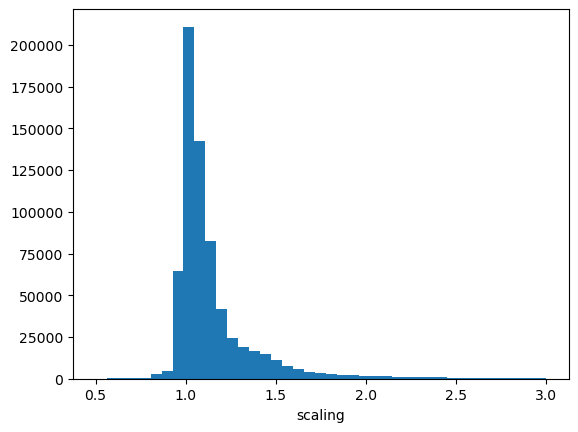

In [9]:
bins = np.linspace(0.5, 3, 42)

counts, _, _ = plt.hist(light_scalings, bins)
plt.xlabel("scaling")
plt.show()

In [10]:


Rlight_scalings = []
Rrun_indexes    = []
Rrunss  = []
Rsruns = []
Rzeniths = []

# Iterate through bins
for i in range(len(bins) - 1):
    # Define the current bin
    bin_start, bin_end = bins[i], bins[i + 1]
    
    # Get indices of elements in the current bin
    indices = np.where((light_scalings >= bin_start) & (light_scalings <= bin_end))[0]
    
    # Take only N elements from the current bin
    selected_indices = indices[:N]
    
    # Append selected elements to the reduced data
    Rlight_scalings.extend(np.array(light_scalings)[selected_indices])
    Rrun_indexes.extend(np.array(run_indexes)[selected_indices])
    Rrunss.extend(np.array(runss)[selected_indices])
    Rsruns.extend(np.array(sruns)[selected_indices])
    Rzeniths.extend(np.array(zeniths)[selected_indices])

In [11]:
# for _ in range(50):
#     N = 5
#     for i, b in enumerate(bins[:-1]):

#         n = 0
#         for j, scale in enumerate(zeniths):

#             if scale > bins[i] and scale < bins[i+1]:
#                 if n > N:
#                     run_indexes.pop(j)
#                     light_scalings.pop(j)
#                     runss.pop(j)
#                     sruns.pop(j)
#                     zeniths.pop(j)
#                 n = n + 1

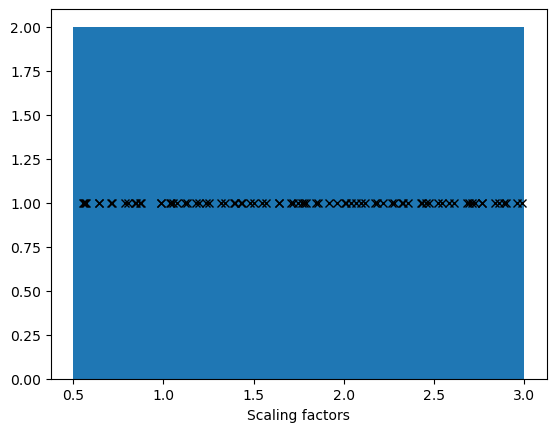

In [12]:
plt.hist(Rlight_scalings, bins)
plt.plot(Rlight_scalings, np.repeat(1, len(Rzeniths)), "xk")
plt.xlabel("Scaling factors")
plt.show()

## Write it to a job summary file

In [13]:
file = open(jobconfig_fname, "w")
file.write("# Job configuration file\n# RUN_INDEX-RUN-SUBRUN-light yields scaling factors applied")

for i in range(len(Rrun_indexes)):
        
    file.write(f"\n{0}-{Rrunss[i]}-{Rsruns[i]}-{1.},{Rlight_scalings[i]}")

    for scale in np.linspace(Rlight_scalings[i] - 0.4, Rlight_scalings[i] + 0.15, sampling_number):
        file.write(f",{scale}")

file.close()  